# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.248  train_ave_acc: 0.562  (2.25s - 65.14s remaining) ave_loss: 0.2481544853305537 ave_acc: 0.5615109952416
EPOCH: 2.000  train_ave_loss: 0.238  train_ave_acc: 0.612  (4.45s - 62.33s remaining) ave_loss: 0.23842012845089008 ave_acc: 0.6122052637220291
EPOCH: 3.000  train_ave_loss: 0.230  train_ave_acc: 0.631  (6.52s - 58.66s remaining) ave_loss: 0.23001627452518583 ave_acc: 0.6313681173158942
EPOCH: 4.000  train_ave_loss: 0.226  train_ave_acc: 0.622  (8.60s - 55.89s remaining) ave_loss: 0.22627573644966323 ave_acc: 0.6223112137194033
EPOCH: 5.000  train_ave_loss: 0.222  train_ave_acc: 0.639  (10.72s - 53.59s remaining) ave_loss: 0.2220453667588248 ave_acc: 0.6387433616247739
EPOCH: 6.000  train_ave_loss: 0.219  train_ave_acc: 0.635  (12.82s - 51.26s remaining) ave_loss: 0.2190375223406249 ave_acc: 0.6354637630117791
EPOCH: 7.000  train_ave_loss: 0.215  train_ave_acc: 0.654  (14.91s - 48.98s remaining) ave_loss: 0.2145518111638572 ave_acc: 0.6542878289039

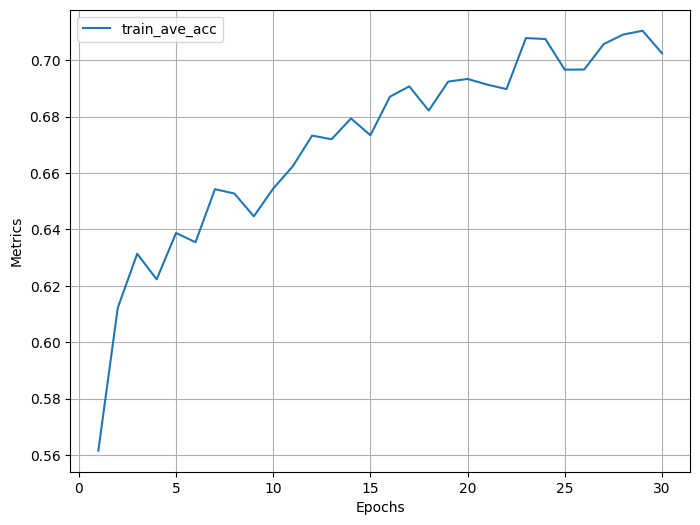

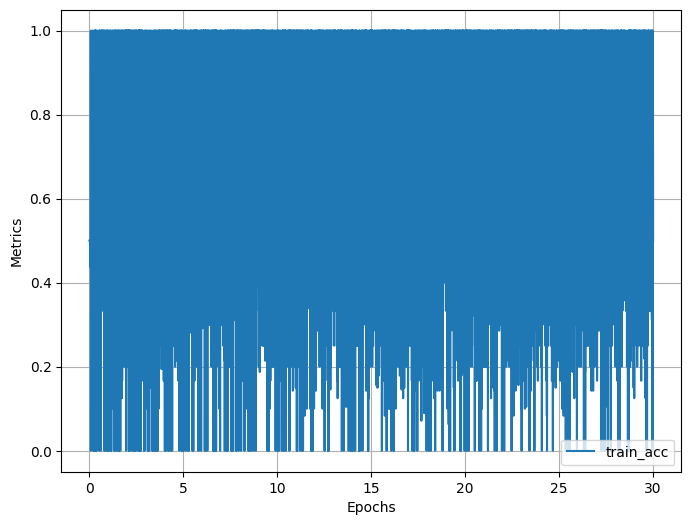

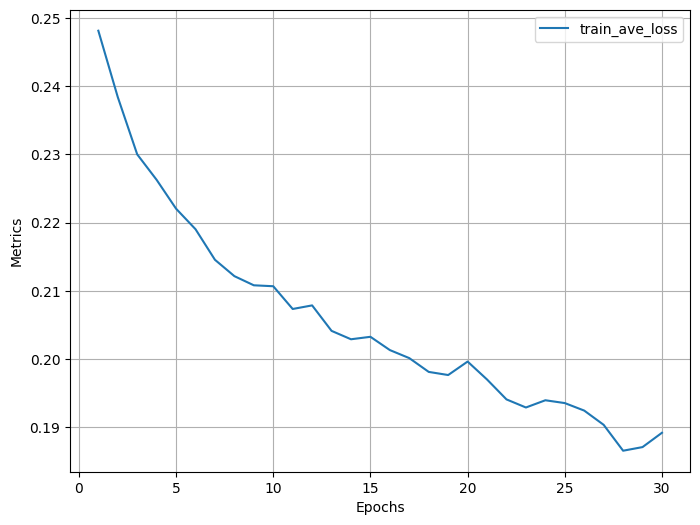

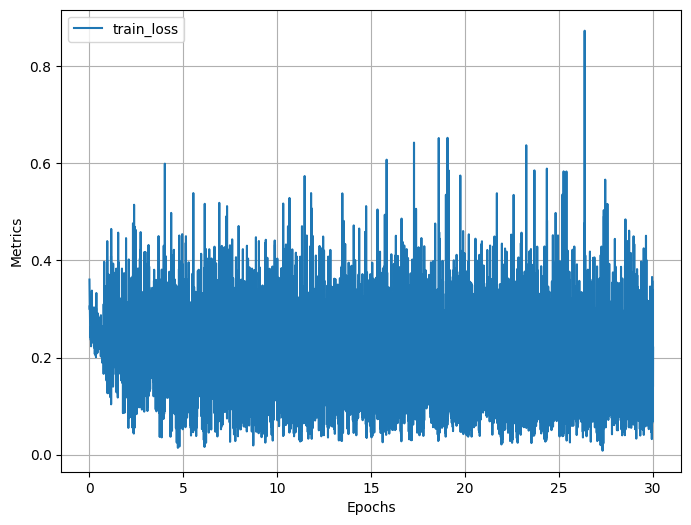

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5461346633416458
NN MC MSE: 0.267191308606638
NN MC Seq Accuracy: 0.600997506234414
NN MC Seq MSE: 0.2536821389934833


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.135  train_ave_acc: 0.509  (1.99s - 57.70s remaining) ave_loss: 0.13540061122445593 ave_acc: 0.5088333709512318
EPOCH: 2.000  train_ave_loss: 0.124  train_ave_acc: 0.547  (3.94s - 55.12s remaining) ave_loss: 0.12431989556118365 ave_acc: 0.5465206448115598
EPOCH: 3.000  train_ave_loss: 0.120  train_ave_acc: 0.548  (5.90s - 53.11s remaining) ave_loss: 0.1199886508100281 ave_acc: 0.548373199038618
EPOCH: 4.000  train_ave_loss: 0.116  train_ave_acc: 0.557  (7.82s - 50.84s remaining) ave_loss: 0.11568048399739252 ave_acc: 0.5574368078895834
EPOCH: 5.000  train_ave_loss: 0.114  train_ave_acc: 0.576  (9.77s - 48.86s remaining) ave_loss: 0.11383996281193848 ave_acc: 0.5758545155484933
EPOCH: 6.000  train_ave_loss: 0.111  train_ave_acc: 0.571  (11.70s - 46.81s remaining) ave_loss: 0.11149738856271739 ave_acc: 0.5708958824694851
EPOCH: 7.000  train_ave_loss: 0.096  train_ave_acc: 0.613  (13.63s - 44.80s remaining) ave_loss: 0.0962192170387489 ave_acc: 0.6127854344

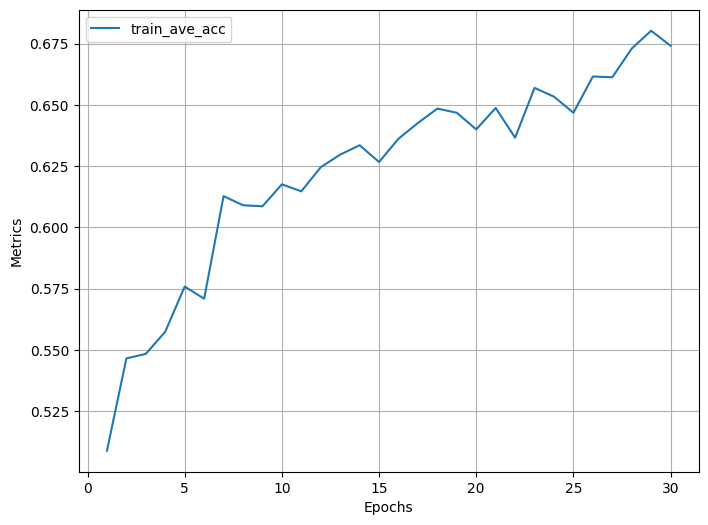

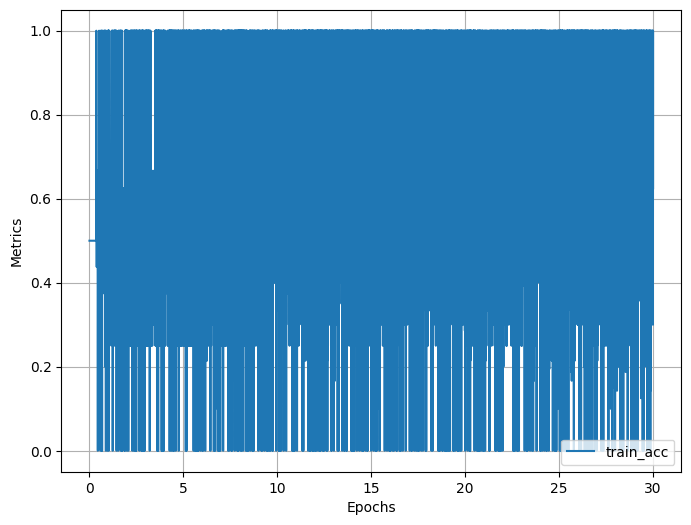

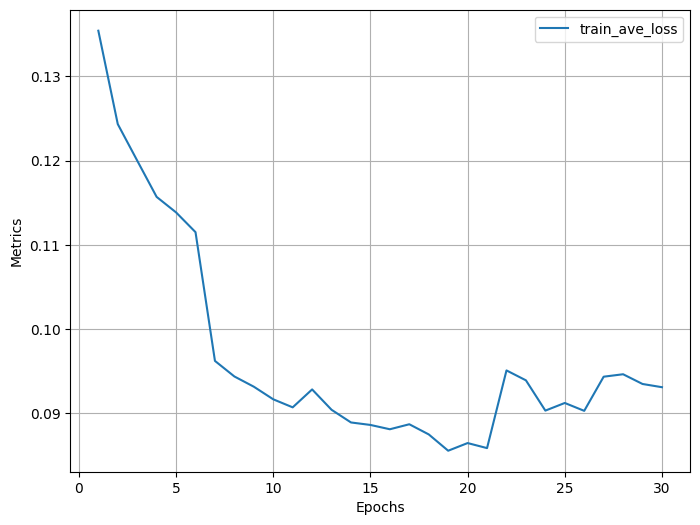

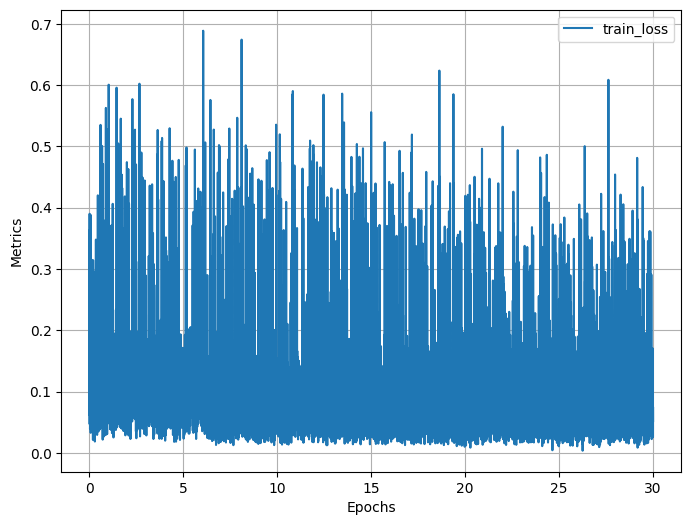

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5461346633416458
NN Sarsa MSE: 0.27445943031191905
NN Sarsa Seq Accuracy: 0.5473815461346634
NN Sarsa Seq MSE: 0.25889321218612255


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.091  train_ave_acc: 0.704  (2.03s - 58.93s remaining) ave_loss: 0.09069547983012066 ave_acc: 0.7035674517637699
EPOCH: 2.000  train_ave_loss: 0.094  train_ave_acc: 0.702  (4.01s - 56.13s remaining) ave_loss: 0.09394618365886317 ave_acc: 0.7022004094359074
EPOCH: 3.000  train_ave_loss: 0.093  train_ave_acc: 0.702  (5.92s - 53.29s remaining) ave_loss: 0.09298189132149356 ave_acc: 0.7016254695475976
EPOCH: 4.000  train_ave_loss: 0.091  train_ave_acc: 0.683  (7.86s - 51.07s remaining) ave_loss: 0.09132999381394592 ave_acc: 0.6825160953592337
EPOCH: 5.000  train_ave_loss: 0.090  train_ave_acc: 0.704  (9.77s - 48.86s remaining) ave_loss: 0.09046649717783167 ave_acc: 0.7040183439879231
EPOCH: 6.000  train_ave_loss: 0.091  train_ave_acc: 0.710  (11.70s - 46.80s remaining) ave_loss: 0.09096604982074186 ave_acc: 0.709639729473906
EPOCH: 7.000  train_ave_loss: 0.098  train_ave_acc: 0.687  (13.60s

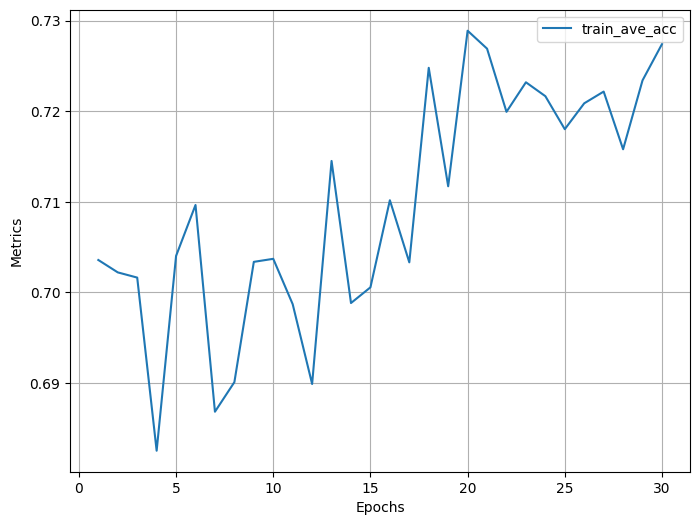

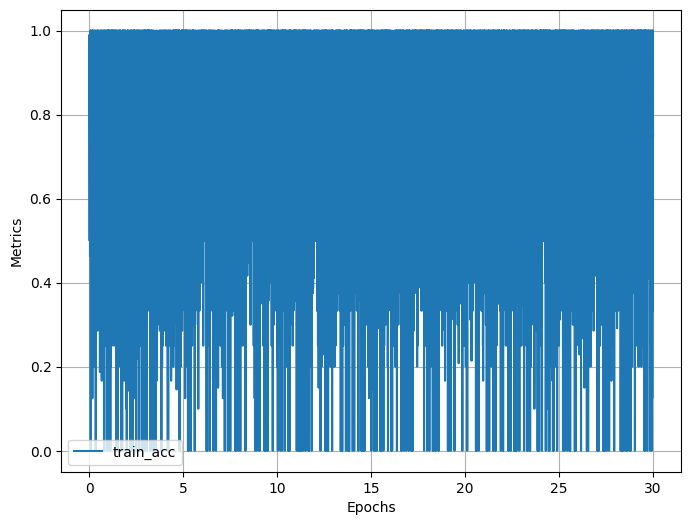

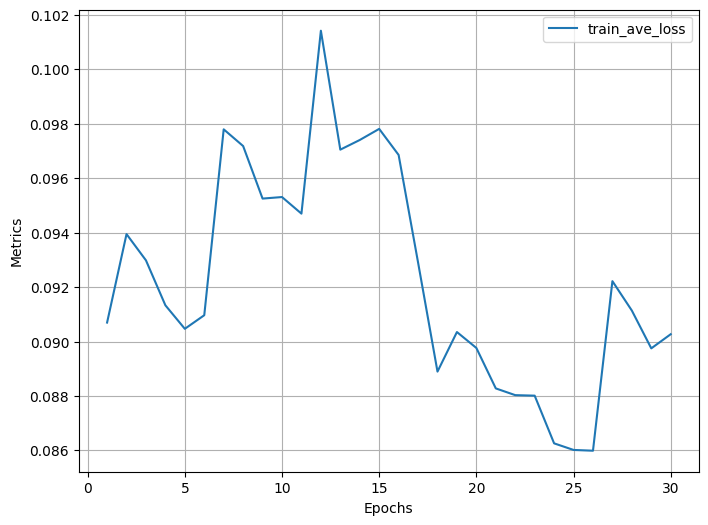

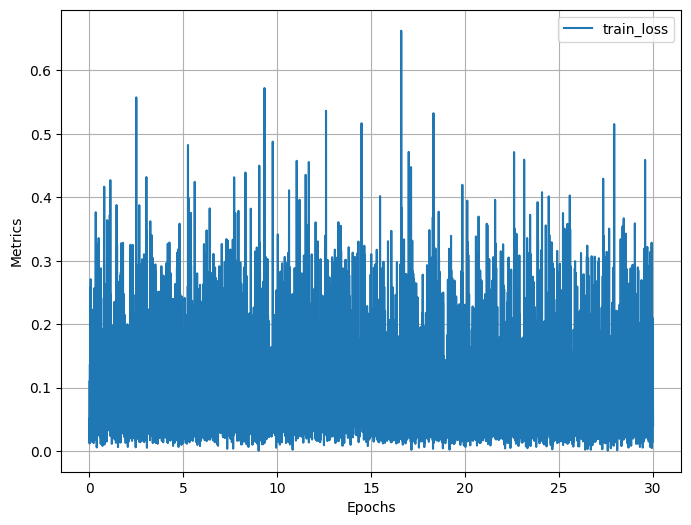

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5461346633416458
NN Sarsa With MC Init MSE: 0.29722964214673725
NN Sarsa With MC Init Seq Accuracy: 0.6059850374064838
NN Sarsa With MC Init Seq MSE: 0.23641647453620934


In [12]:
import os

model_dirpath = 'experiment_models/lzy_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions